## SHAP profiles - explanations of individual predictions
 
TreeExplainer source: https://github.com/slundberg/shap

TreeExplainer assigns credit to each feature for each prediction.

**Input**:
* All paralog pair feature values
* Predictions for all pairs
* Random forest classifier

**Output:**
* SHAP values associated with all features in all pairs
* Table S8: SHAP values and prediction for all features/pairs

In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport graphing_params

import pickle
import os, sys
stdout = sys.stdout
import shap
sys.stdout = stdout

# load JS visualization code to notebook
shap.initjs()

mpl.rcParams.update({'ytick.labelsize':9})

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_features = get_local_data_path([],'feature_list.txt')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')
file_feature_names = get_local_data_path([],'feature_names.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_all_predictions = get_local_data_path(['results'], 'predictions_all_pairs.csv')
file_depmap_pairs = get_local_data_path(['results'], 'bronze_standard_SL_pairs_24_09_20.csv')

# Output
file_all_shap_values = get_local_data_path(['results'], 'shap_values_all_pairs_11_10_20.csv')
file_feature_zscores = get_local_data_path(['processed','paralog_features'], 'all_features_zscores.csv')
file_table_s8 = get_local_data_path(['supplemental_files'], 'Table_S8.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data: all feature annotated paralog pairs + their predictions

In [3]:
all_pairs = pd.read_csv(file_annot_pairs)
all_pairs[:1]

,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,WGD,...,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_pombe_ortholog,has_essential_pombe_ortholog,has_single_essential_pombe_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,False,...,False,False,False,False,False,False,3,210.95,0.0,False


In [6]:
full_feature_list= pd.read_csv(file_features)
features = list(full_feature_list[full_feature_list.include==1].feature)
print('N features', len(features))

N features 22


In [7]:
feature_labels = pd.read_csv(file_feature_names, sep='\t')
feature_labels.loc[feature_labels.feature=='mean_complex_essentiality', 'simple_name'] = ' Essentiality of Protein Complex(es)'
feature_labels[:1]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence


In [9]:
all_predictions = pd.read_csv(file_all_predictions)
all_predictions[:1]

,prediction_rank,A1,A2,A1_entrez,A2_entrez,validated_SL,prediction_score,depmap_hit,thompson_hits
0,1,SMARCA2,SMARCA4,6595,6597,True,0.421874,True,2.0


### Load RF classifier and generate SHAP values for all paralog pairs

In [10]:
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

In [11]:
explainer = shap.TreeExplainer(RF, feature_perturbation = "tree_path_dependent")
all_shap_values_raw = explainer.shap_values(all_pairs[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [12]:
print('Expected value:', explainer.expected_value[1])

Expected value: 0.035075611767940613


In [13]:
all_shap_values = pd.DataFrame(all_shap_values_raw[1], columns=features)
all_shap_values = pd.concat([all_pairs[['A1','A2','A1_entrez','A2_entrez']], all_shap_values], axis=1)
all_shap_values.to_csv(file_all_shap_values, index=0)
all_shap_values[:2]

,A1,A2,A1_entrez,A2_entrez,min_sequence_identity,closest,WGD,family_size,cds_length_ratio,shared_domains,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A1BG,OSCAR,1,126014,-0.000644,-0.003123,-0.000917,0.000480,-0.000116,-0.000004,...,-0.000321,-0.003914,-0.000083,-0.000140,-0.000094,-0.004551,-0.000559,0.000528,-0.000186,0.000049
1,A1BG,TARM1,1,441864,-0.000623,-0.003080,-0.000923,0.000601,0.000422,-0.000004,...,-0.000313,-0.004139,-0.000088,-0.000137,-0.000145,-0.004728,-0.000563,0.003971,-0.000155,0.000120


In [14]:
# Also save as Table S8 (add predictions to this)
table_s8 = pd.merge(all_predictions[['prediction_rank','A1','A2','A1_entrez','A2_entrez','prediction_score']], all_shap_values)
assert(table_s8.shape[0] == all_shap_values.shape[0])
table_s8.to_csv(file_table_s8, index=0)
table_s8[:2]

,prediction_rank,A1,A2,A1_entrez,A2_entrez,prediction_score,min_sequence_identity,closest,WGD,family_size,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,1,SMARCA2,SMARCA4,6595,6597,0.421874,0.159308,0.026656,0.006628,0.011195,...,0.002839,0.051524,0.000752,0.001757,0.001221,0.042600,0.004616,-0.001090,0.001168,0.002376
1,2,EXOC6,EXOC6B,54536,23233,0.411001,0.160649,0.025956,0.005120,0.013730,...,0.003274,0.058590,0.000486,0.001863,0.001887,0.011073,0.003578,0.002338,-0.001805,0.000842


### Global top SHAP values

In [92]:
# Can load here instead of running the above section when re-running notebook
all_shap_values = pd.read_csv(file_all_shap_values)

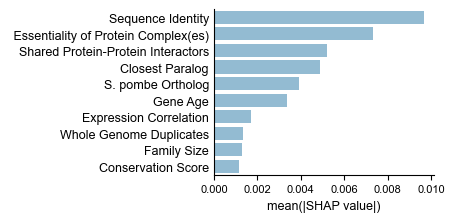

In [16]:
# Top 10 most predictive features (for all paralog pairs)
df = all_shap_values.iloc[:,4:].abs().mean().sort_values(ascending=False).reset_index()
df.columns = ['feature','value']
df = pd.merge(df, feature_labels)
top_features = df.feature.values

f, ax = plt.subplots(1, 1, figsize=(4.6,2.3))
sns.barplot(y=df[:10]['simple_name'], x=df[:10]['value'], color=sns.color_palette("Blues")[2])
ax.set_xlabel('mean(|SHAP value|)')
_ = ax.set_ylabel(''); ax.tick_params(axis='y', which='both', length=0);
plt.tight_layout()

### Compute z-scores for all feature values

In [17]:
# Calculate zscores for each feature for all pairs
zmin=-2; zmax=2
def calculate_zscores_for_feature(x):
    dtype = all_pairs[x.name].dtype
    if dtype == 'float64' or dtype=="int64":
        return pd.Series(stats.zscore(np.array(x.values, dtype=np.float64))).clip(lower=zmin, upper=zmax)
    elif dtype == 'bool':
        return x.apply(lambda y: 2 if y==True else -2)
    else:
        print('Unexpected type:', dtype)

all_pairs_zscores = all_pairs[features].apply(calculate_zscores_for_feature)
all_pairs_zscores = pd.concat([all_pairs[['A1','A2','A1_entrez','A2_entrez']], all_pairs_zscores], axis=1)

#all_pairs_zscores.to_csv(file_feature_zscores, index=0)
assert(all_pairs_zscores.shape[0] == all_pairs.shape[0])
all_pairs_zscores[:1]

,A1,A2,A1_entrez,A2_entrez,min_sequence_identity,closest,WGD,family_size,cds_length_ratio,shared_domains,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A1BG,OSCAR,1,126014,-1.108744,-2,-2,-1.010515,-1.242049,0.69377,...,-2,-0.304106,-0.429845,-2,-0.472214,-0.30504,-0.44253,-0.111746,0.004431,-0.141276


#### Merge feature values, feature z-scores, shap values and predictions

In [18]:
assert(all_shap_values.shape[0] == all_pairs_zscores.shape[0])
# Merge feature zscores and shap values
all_shap_and_zscore = pd.merge(
    pd.melt(all_pairs_zscores, id_vars=['A1','A2','A1_entrez','A2_entrez']).rename(columns={'value':'zscore'}),
    pd.melt(all_shap_values, id_vars=['A1','A2','A1_entrez','A2_entrez']).rename(columns={'value':'shap_value'})
)
# Add feature values - round float64s to 3 decimal places
all_feature_values = all_pairs[['A1','A2','A1_entrez','A2_entrez']+features]
all_feature_values = all_feature_values.apply(lambda x: round(x, 3) if x.infer_objects().dtype == 'float64' else x)
all_shap_and_zscore = pd.merge(
    all_shap_and_zscore, 
    pd.melt(all_feature_values, id_vars=['A1','A2','A1_entrez','A2_entrez']).rename(columns={'value':'feature_value'})
)

all_shap_and_zscore = all_shap_and_zscore.rename(columns={'variable':'feature'})
display(all_shap_and_zscore[:1])

# Add prediction
all_shap_and_zscore = pd.merge(all_shap_and_zscore, all_predictions[['A1','A2','prediction_rank']])
assert(all_shap_and_zscore.shape[0] == all_pairs_zscores.shape[0]*len(features))

# Add feature simple names
all_shap_and_zscore = pd.merge(all_shap_and_zscore, feature_labels.drop(columns=['category']))

# Add global feature ranks (for use on web page)
all_shap_and_zscore = pd.merge(all_shap_and_zscore, pd.DataFrame(top_features, columns=['feature']).reset_index()\
                                                      .rename(columns={'index':'global_feat_rank'}))
all_shap_and_zscore[:1]

,A1,A2,A1_entrez,A2_entrez,feature,zscore,shap_value,feature_value
0,A1BG,OSCAR,1,126014,min_sequence_identity,-1.108744,-0.000644,0.127


,A1,A2,A1_entrez,A2_entrez,feature,zscore,shap_value,feature_value,prediction_rank,simple_name,global_feat_rank
0,A1BG,OSCAR,1,126014,min_sequence_identity,-1.108744,-0.000644,0.127,21254,Sequence Identity,0


In [19]:
print('Min and max SHAP values:', all_shap_and_zscore.shap_value.min(), ',', all_shap_and_zscore.shap_value.max())

Min and max SHAP values: -0.02491629760805337 , 0.16697673492856202


### SHAP plots for individual paralog pairs

In [22]:
zmin=-2; zmax=2
palette = sns.color_palette("coolwarm", 5)
cmap = mpl.colors.ListedColormap(palette.as_hex())

def draw_colorbar(f, ax, cmap, zmin, zmax, height=0.5, width=0.015, xpadding=0.03, ypadding=0):
    bbox_ax = ax.get_position()
    # colorbar is bounded by [x0, y0, x_width, y_width]
    cbar_ax = f.add_axes([bbox_ax.x1+xpadding, bbox_ax.y0+ypadding, width, (bbox_ax.y1-bbox_ax.y0)*height])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(zmin, zmax))
    cbar = f.colorbar(sm, cax=cbar_ax, ticks=[-1.2, -0.4, 0.4, 1.2])
    cbar.set_label('Feature z-score', rotation=270, labelpad=10)
    cbar.outline.set_visible(False)
    cbar_ax.tick_params(right=False, pad=0)
    for t in cbar_ax.get_yticklabels(): t.set_fontsize(8)
    return cbar_ax

def draw_shap_plot_for_pair(A1, A2, ax, feature_order=[], n=10):
    pair = pd.DataFrame({'A1':A1, 'A2':A2}, index=[0])
    # DF incl. columns: feature, shap_value, zcore
    df = pd.merge(pair, all_shap_and_zscore)
    # Order features
    if len(feature_order)==0:
        df = df[df.index.isin(df.shap_value.abs().nlargest(n=n).index)].sort_values('shap_value', ascending=False)
    else:
        df = df.set_index('feature').loc[feature_order,:].reset_index()
    # Map zscore to a discrete color range
    df['color_idx'] = df.zscore.apply(lambda x: np.round(((x-zmin)/(zmax-zmin)) * (len(palette)-1)).astype(np.int32))
    sns.barplot(x=df.shap_value, y=df.simple_name, ax=ax, palette=np.array(palette)[df.color_idx.values], saturation=1)
    ax.tick_params(axis='y', which='both', length=0); ax.set_ylabel('')
    ax.set_title(A1+'/'+A2, fontsize=9, fontweight='bold', fontstyle="italic")
    ax.set_xlabel('SHAP value')

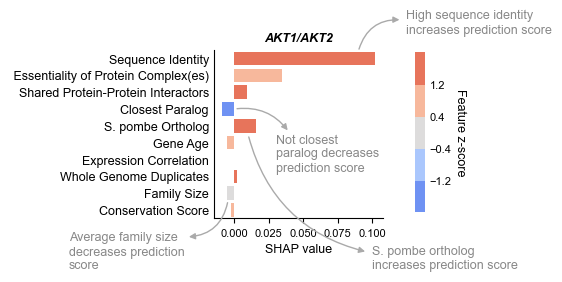

In [23]:
f, ax = plt.subplots(1, 1, figsize=(4,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('AKT1', 'AKT2', ax, feature_order=top_features[:10])
plt.tight_layout()

# Draw annotations
ax.text(0.125, -1.5, 'High sequence identity\nincreases prediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0.09, -0.4), xycoords='data', xytext=(0.122, -2.3), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#aaa"))

ax.text(0.03, 6.7, 'Not closest\nparalog decreases\nprediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0, 3), xycoords='data', xytext=(0.04, 4.4), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.3", color="#aaa"))

ax.text(-0.12, 12.5, 'Average family size\ndecreases prediction\nscore', fontsize=9, color='#888')
ax.annotate("", xy=(-0.0045, 8.4), xycoords='data', xytext=(-0.035, 10.6), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#aaa"))

ax.text(0.1, 12.5, 'S. pombe ortholog\nincreases prediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0.01, 4.5), xycoords='data', xytext=(0.097, 11.5), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=-0.3", color="#aaa"))

cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.95, width=0.025, xpadding=0.08, ypadding=0.025)
#f.savefig("../figures/for_paper/akt12_shap_annotated.svg", bbox_inches="tight", dpi=400)

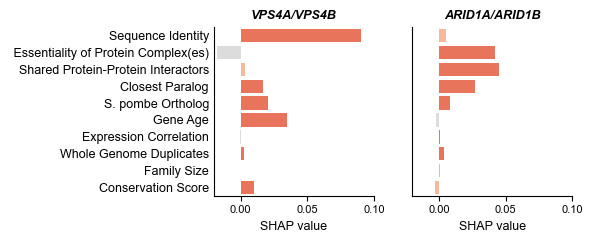

In [24]:
f, ax = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('ARID1A', 'ARID1B', ax[1], feature_order=top_features[:10])
draw_shap_plot_for_pair('VPS4A', 'VPS4B', ax[0], feature_order=top_features[:10])
ax[0].set_xlim([-0.02, 0.1])
plt.tight_layout()
#draw_colorbar(f, ax[1], cmap, zmin, zmax, height=0.95)
f.savefig("../figures/for_paper/vps4ab_arid1ab_shap.svg", bbox_inches="tight", dpi=300) # bbox_extra_artists=[cbar]

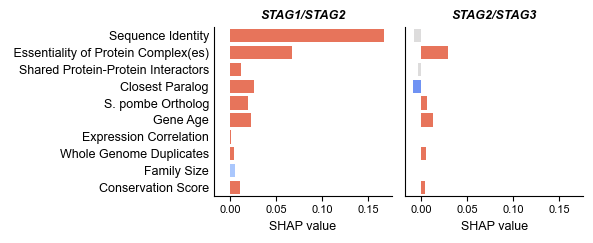

In [25]:
f, ax = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('STAG1', 'STAG2', ax[0], feature_order=top_features[:10])
draw_shap_plot_for_pair('STAG2', 'STAG3', ax[1], feature_order=top_features[:10])
plt.tight_layout()
#cbar = draw_colorbar(f, ax[1], cmap, zmin, zmax, height=0.95)
f.savefig("../figures/for_paper/stag123_shap.svg", bbox_inches="tight", dpi=300)

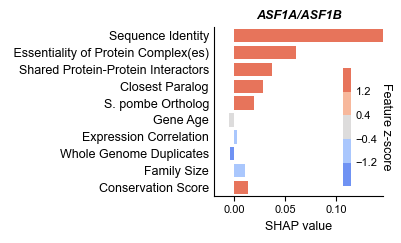

In [27]:
f, ax = plt.subplots(1, 1, figsize=(4,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('ASF1A', 'ASF1B', ax, feature_order=top_features[:10])
plt.tight_layout()
ax.set_xlim([-0.02, 0.146])
cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.7, width=0.02, xpadding=-0.1, ypadding=0.04)
#f.savefig("../figures/for_paper/asf1ab_shap.svg", bbox_inches="tight", dpi=300)

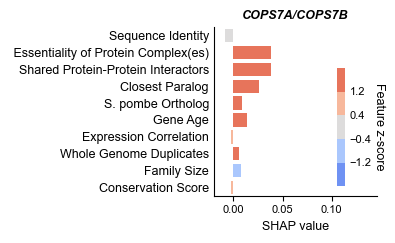

In [28]:
f, ax = plt.subplots(1, 1, figsize=(4,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('COPS7A', 'COPS7B', ax, feature_order=top_features[:10])
plt.tight_layout()
ax.set_xlim([-0.02, 0.146])
cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.7, width=0.02, xpadding=-0.1, ypadding=0.04)
#f.savefig("../figures/for_paper/cops7ab_shap.svg", bbox_inches="tight", dpi=300)

### Waterfall plots to show prediction rank for above SHAP profile examples

In [52]:
def draw_waterfall_plot(df, color, label, ax, alpha=1):
    sns.scatterplot(df.index, df.prediction_score, ax=ax, linewidth=0, s=20, alpha=alpha, color=color, label=label)
    ax.set_ylabel('Prediction')
    ax.set_xlabel('Prediction Rank')

% with a prediction score above 0.1: 3.13%


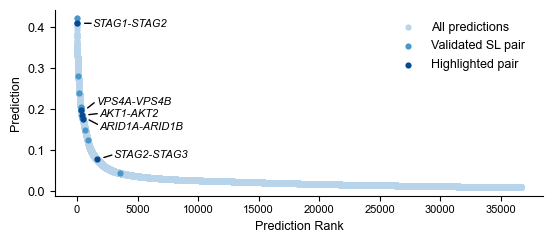

In [53]:
# Waterfall plot of all predictions, with some highlighted examples
highlighted_pairs = pd.DataFrame([['ARID1A','ARID1B'],['STAG1','STAG2'],['VPS4A','VPS4B'],
                                  ['STAG2','STAG3'],['AKT1','AKT2']], columns=['A1','A2'])
df = pd.merge(all_predictions, highlighted_pairs, how='left', indicator='example')
df.example = df.example=='both'
print('%% with a prediction score above 0.1: %.2f%%' % (df[df.prediction_score > 0.1].shape[0] / df.shape[0]*100))

f, ax = plt.subplots(1, 1, figsize=(5.6,2.5))
pal = sns.color_palette("Blues", n_colors=9)
draw_waterfall_plot(df, pal[2], "All predictions  ", ax)
draw_waterfall_plot(df[df.validated_SL], pal[5], "Validated SL pair  ", ax)
draw_waterfall_plot(df[df.example], pal[8], "Highlighted pair  ", ax)
plt.tight_layout()

# Plot annotations
txt_fontsize = 8
ax.text(1300, 0.4, 'STAG1-STAG2', fontsize=txt_fontsize, fontstyle="italic")
ax.annotate("", xy=(400, 0.41), xycoords='data', xytext=(1400, 0.41), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(1600, 0.21, 'VPS4A-VPS4B', fontsize=txt_fontsize, fontstyle="italic")
ax.annotate("", xy=(700, 0.199), xycoords='data', xytext=(1600, 0.22), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(1800, 0.18, 'AKT1-AKT2', fontsize=txt_fontsize, fontstyle="italic")
ax.annotate("", xy=(750, 0.186), xycoords='data', xytext=(1900, 0.19), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(1800, 0.15, 'ARID1A-ARID1B', fontsize=txt_fontsize, fontstyle="italic")
ax.annotate("", xy=(800, 0.177), xycoords='data', xytext=(1900, 0.16), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(3000, 0.08, 'STAG2-STAG3', fontsize=txt_fontsize, fontstyle="italic")
_ = ax.annotate("", xy=(2000, 0.08), xycoords='data', xytext=(3100, 0.09), textcoords='data', arrowprops=dict(arrowstyle="-"))

#f.savefig("../figures/for_paper/waterfall_plot_1.svg", bbox_inches="tight", dpi=300)

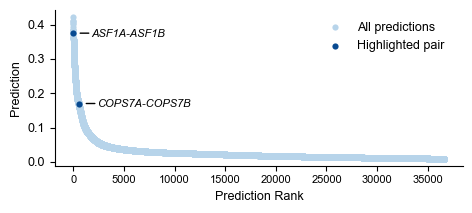

In [54]:
# Waterfall plot of all predictions, with some highlighted examples
highlighted_pairs = pd.DataFrame([['ASF1A','ASF1B'],['COPS7A', 'COPS7B']], columns=['A1','A2'])
df = pd.merge(all_predictions, highlighted_pairs, how='left', indicator='example')
df.example = df.example=='both'

f, ax = plt.subplots(1, 1, figsize=(4.8,2.2))
pal = sns.color_palette("Blues", n_colors=9)
draw_waterfall_plot(df, pal[2], "All predictions  ", ax)
draw_waterfall_plot(df[df.example], pal[8], "Highlighted pair  ", ax)
plt.tight_layout()

# Plot annotations
ax.text(1800, 0.365, 'ASF1A-ASF1B', fontsize=txt_fontsize, fontstyle="italic")
ax.annotate("", xy=(400, 0.375), xycoords='data', xytext=(1800, 0.375), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(2400, 0.16, 'COPS7A-COPS7B', fontsize=txt_fontsize, fontstyle="italic")
_ = ax.annotate("", xy=(1000, 0.17), xycoords='data', xytext=(2400, 0.17), textcoords='data', arrowprops=dict(arrowstyle="-"))

#f.savefig("../figures/for_paper/waterfall_plot_2.svg", bbox_inches="tight", dpi=300)

### Predictions for all paralog pairs that include *AKT1*

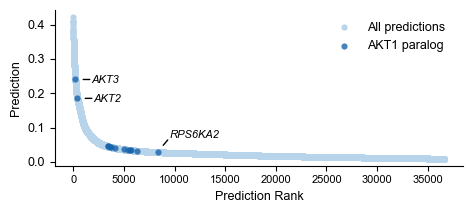

In [56]:
highlighted_pairs = pd.DataFrame(all_predictions[all_predictions.A1=='AKT1'][['A1','A2']].values, columns=['A1','A2'])
df = pd.merge(all_predictions, highlighted_pairs, how='left', indicator='example')
df.example = df.example=='both'

f, ax = plt.subplots(1, 1, figsize=(4.8,2.2))
pal = sns.color_palette("Blues", n_colors=9)
draw_waterfall_plot(df, pal[2], "All predictions  ", ax)
draw_waterfall_plot(df[df.example], pal[7], "AKT1 paralog  ", ax, alpha=0.8)
plt.tight_layout()

# Annotate genes
ax.text(1800, 0.23, 'AKT3', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(700, 0.24), xycoords='data', xytext=(1900, 0.24), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(2000, 0.175, 'AKT2', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(900, 0.185), xycoords='data', xytext=(2100, 0.185), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(9500, 0.07, 'RPS6KA2', fontsize=8, fontstyle="italic")
_ = ax.annotate("", xy=(8700, 0.042), xycoords='data', xytext=(9500, 0.07), textcoords='data', arrowprops=dict(arrowstyle="-"))

#f.savefig("../figures/for_paper/waterfall_plot_AKT1.svg", bbox_inches="tight", dpi=300)

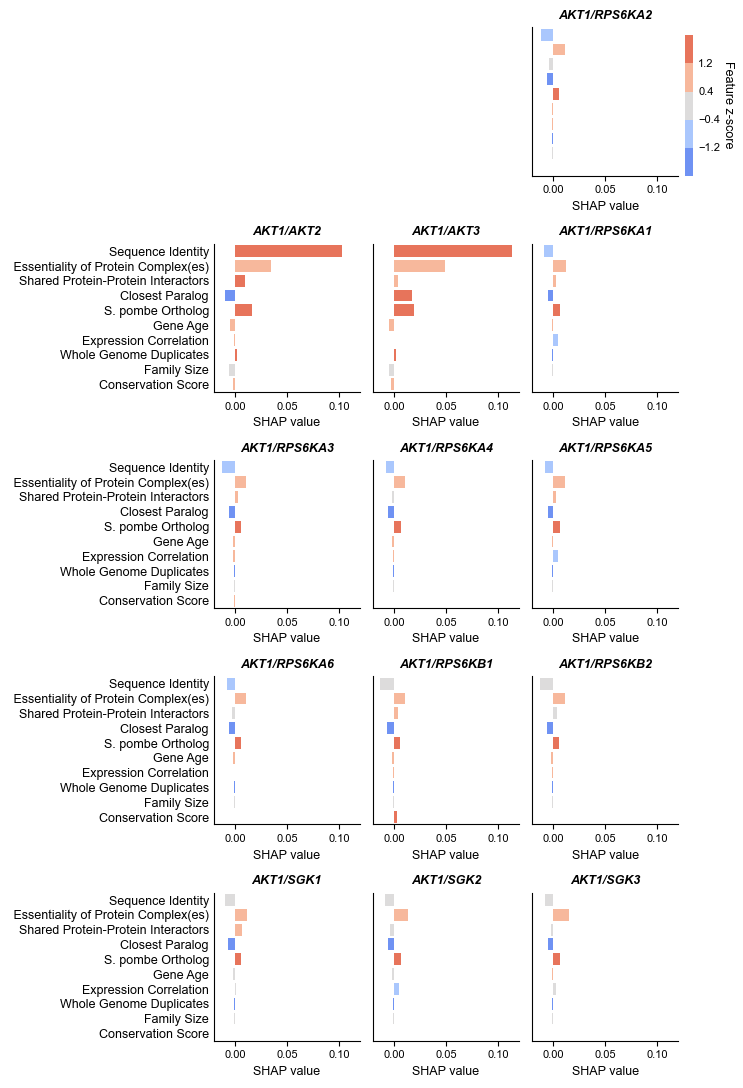

In [57]:
f, axes = plt.subplots(nrows=5, ncols=3, figsize=(6.95, 10.95), sharex=True, sharey=True)
axes = axes.flatten()
for idx, row in all_pairs[all_pairs.A1=='AKT1'][['A1','A2']].reset_index(0).iterrows():
    if idx < 3: ax = axes[idx+3]
    elif idx == 3: ax = axes[2]
    else: ax = axes[idx+2]
    draw_shap_plot_for_pair(row.A1, row.A2, ax, feature_order=top_features[:10])
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].axis('off'); axes[1].axis('off')
plt.tight_layout()
draw_colorbar(f, axes[2], cmap, zmin, zmax, height=0.95, xpadding=0.01, width=0.012)
#f.savefig("../figures/for_paper/shap_plot_AKT1.svg", bbox_inches="tight", dpi=300)